# Bank Customer Churn Prediction - Random Forest Classifier

**Objective:** Predict which bank customers are likely to churn based on their demographic and financial data

**Dataset:** BankChurners.csv  
**Source:** Kaggle

**Steps:**
1. Data cleaning & preprocessing
2. Train/Test split
3. Model training
4. Model evaluation
5. Improve the model with class weighting
6. Tune hyperparameters for the best model
7. Feature importance
8. Compare with logistic regression & XGBoost
9. Save model for deployment

In [168]:
#Import relevant libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

In [169]:
#Load data set
raw_csv_data = pd.read_csv("Churn_Modelling.csv")
raw_csv_data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9999,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
10000,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


In [170]:
#Copy to another csv & check data/missing values/ understand columns & values
df = raw_csv_data.copy()
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,3,15619304,Onio,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,4,15701354,Boni,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,9998,15584532,Liu,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
9999,9999,15682355,Sabbatini,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1
10000,10000,15628319,Walker,792,France,Female,28.0,4,130142.79,1,1.0,0.0,38190.78,0


## Data cleaning & preprocessing

In [171]:
#drop duplicates
df.drop_duplicates(inplace=True)

In [172]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 10000
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        9999 non-null   object 
 5   Gender           10000 non-null  object 
 6   Age              9999 non-null   float64
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        9999 non-null   float64
 11  IsActiveMember   9999 non-null   float64
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 1.1+ MB


RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          1
Gender             0
Age                1
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          1
IsActiveMember     1
EstimatedSalary    0
Exited             0
dtype: int64

In [173]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,9999.000000,10000.000000,10000.000000,10000.000000,9999.000000,9999.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.923095,5.012800,76485.889288,1.530200,0.705471,0.515052,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487635,2.892174,62397.405202,0.581654,0.455854,0.499798,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.000000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.000000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.000000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [174]:
#After checking the values, we can start dropping what it is not useful for this project and double-check if they were dropped
df.drop(["Surname", "RowNumber", "CustomerId"],axis=1, inplace=True)
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42.0,2,0.00,1,1.0,1.0,101348.88,1
1,608,Spain,Female,41.0,1,83807.86,1,0.0,1.0,112542.58,0
2,502,France,Female,42.0,8,159660.80,3,1.0,0.0,113931.57,1
3,699,France,Female,39.0,1,0.00,2,0.0,0.0,93826.63,0
4,850,Spain,Female,43.0,2,125510.82,1,NaN,1.0,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39.0,5,0.00,2,1.0,0.0,96270.64,0
9996,516,France,Male,35.0,10,57369.61,1,1.0,1.0,101699.77,0
9997,709,France,Female,36.0,7,0.00,1,0.0,1.0,42085.58,1
9998,772,Germany,Male,42.0,3,75075.31,2,1.0,0.0,92888.52,1


In [175]:
#Fill numeric missing values with median
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

#keep target 'Exited' safe
num_cols_no_target = [c for c in num_cols if c != "Exited"]

imputer_num = SimpleImputer(strategy="median")
df[num_cols_no_target] = imputer_num.fit_transform(df[num_cols_no_target])

In [176]:
#Categorical imputation (mode) for any remaining object/categorical cols
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
for c in cat_cols:
    if df[c].isnull().any():
        df[c] = df[c].fillna(df[c].mode()[0])

In [177]:
#Geography(one hot encoding) needs to be encode since it is and object & Gender(binary) too
df["Gender"] = df["Gender"].map({"Female": 0, "Male": 1}) #Encode Gender
df = pd.get_dummies(df, columns=["Geography"], drop_first=True) #One-Hot Encode Geography
#Geography becomes Geography_Germany, Geography_Spain (France is the baseline)

In [178]:
#Ensure target is integer
if "Exited" in df.columns:
    df["Exited"] = pd.to_numeric(df["Exited"], errors="coerce").fillna(0).astype(int)

In [179]:
#Final checks
print("\nObject dtype columns (after):", df.select_dtypes(include=['object','category']).columns.tolist())
print("\nAny nulls left?\n", df.isnull().sum().sum())
print("\nDuplicates count:", df.duplicated().sum())
print("\nFinal shape:", df.shape)


Object dtype columns (after): []

Any nulls left?
 0

Duplicates count: 0

Final shape: (10000, 12)


## Train/Test Split


In [180]:
#Baseline Model training

#Define target (Exited) and features
X = df.drop("Exited", axis=1)
y = df["Exited"]

print("Features shape:", X.shape)
print("Target shape:", y.shape)

#Train/Test Split
#80% training, 20%testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,         #20% test
    random_state=42,       #reproducibility
    stratify=y             #keeps churn ratio balanced in train/test
)

print("Training set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Features shape: (10000, 11)
Target shape: (10000,)
Training set: (8000, 11) (8000,)
Test set: (2000, 11) (2000,)


## Model training

In [181]:
rf = RandomForestClassifier(
    n_estimators=200,     #good baseline
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

## Model evaluation

In [182]:
#Baseline Model evaluation

#predictions & metrics
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=3)
roc_auc = roc_auc_score(y_test, y_prob)   #prefer probabilities for ROC-AUC

print("Test Accuracy:", acc)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", report)
print("ROC-AUC (probabilities):", roc_auc)

Test Accuracy: 0.8615

Confusion Matrix:
 [[1537   56]
 [ 221  186]]

Classification Report:
               precision    recall  f1-score   support

           0      0.874     0.965     0.917      1593
           1      0.769     0.457     0.573       407

    accuracy                          0.862      2000
   macro avg      0.821     0.711     0.745      2000
weighted avg      0.853     0.862     0.847      2000

ROC-AUC (probabilities): 0.8557617710160083


Quick comment here:recall score for class 1 (customers who churned). In our baseline, this number is low, meaning the model misses a lot of actual churners

**Observation:**

- Recall for churners (class 1) was low
- This baseline model missed many customers who were actually at risk
- Accuracy seemed decent, but it was misleading because it prioritised the majority class

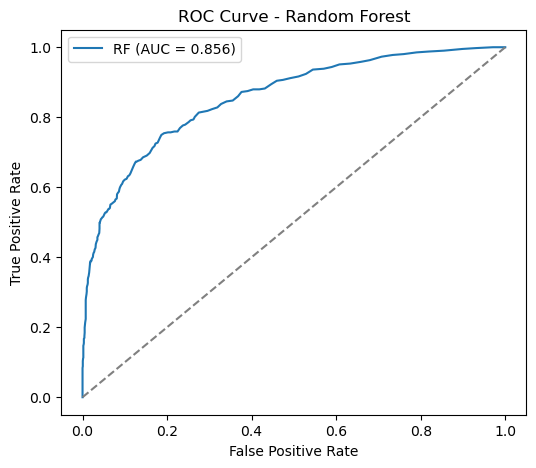

In [183]:
#plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"RF (AUC = {roc_auc:.3f})")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()

## Improve the model with class weighting

In [184]:
#Model training with class weight
rf_bal = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',  #The only change
    random_state=42,
    n_jobs=-1
)
rf_bal.fit(X_train, y_train)

#Model evaluation with class weight
print("\n\nBalanced Class Weight Model")
y_pred_bal = rf_bal.predict(X_test)
y_prob_bal = rf_bal.predict_proba(X_test)[:,1]

print("ROC-AUC Score:", roc_auc_score(y_test, y_prob_bal))
print("\nClassification Report:\n", classification_report(y_test, y_pred_bal, digits=3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))



Balanced Class Weight Model
ROC-AUC Score: 0.853217624404065

Classification Report:
               precision    recall  f1-score   support

           0      0.872     0.969     0.918      1593
           1      0.783     0.442     0.565       407

    accuracy                          0.862      2000
   macro avg      0.827     0.705     0.741      2000
weighted avg      0.854     0.862     0.846      2000


Confusion Matrix:
 [[1543   50]
 [ 227  180]]


The recall for churn (1) actually went down instead of improving it

## Tune hyperparameters for the best model

In [185]:
from sklearn.model_selection import RandomizedSearchCV

#Define the settings we want to test
param_dist = {
    "rf__n_estimators": [100, 200, 400],
    "rf__max_depth": [4, 6, 10, None],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf": [1, 2, 4],
    "rf__max_features": ["sqrt", "log2", 0.6, 0.8]
}

#Pipeline with scaler (not need but good since we already scaled the LRegression model)
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

rs = RandomizedSearchCV(
    pipe,
    param_distributions=param_dist,
    n_iter=30,
    scoring="roc_auc",
    cv=3,
    n_jobs=1,  #safer on macOS
    verbose=1,
    random_state=42
)

rs.fit(X_train, y_train)
best_rf = rs.best_estimator_
print("\nBest hyperparameters:", rs.best_params_)

#Evaluation
y_pred_best = best_rf.predict(X_test)
y_prob_best = best_rf.predict_proba(X_test)[:,1]

print("\nTuned Random Forest")
print("ROC-AUC:", roc_auc_score(y_test, y_prob_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best, digits=3))

Fitting 3 folds for each of 30 candidates, totalling 90 fits

Best hyperparameters: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 2, 'rf__max_features': 0.6, 'rf__max_depth': 10}

Tuned Random Forest
ROC-AUC: 0.859579147714741
Confusion Matrix:
 [[1396  197]
 [ 131  276]]
              precision    recall  f1-score   support

           0      0.914     0.876     0.895      1593
           1      0.584     0.678     0.627       407

    accuracy                          0.836      2000
   macro avg      0.749     0.777     0.761      2000
weighted avg      0.847     0.836     0.840      2000



- The big win (Recall):our new tuned model now catches 67.8% of churners, successfully identifying 276 out of 407 at risk customers in the test set. This is a massive improvement over a baseline model, which would typically miss the vast majority of these customers. From a business standpoint, successfully identifying this many at risk customers is a huge win for retention efforts

- The Trade-Off (Accuracy): Why did accuracy drop? Because the model is now trying much harder to find churners. The "cost" is that it creates more false alarms, incorrectly flagging 197 loyal customers as potential churners (compared to only 56 in the baseline)

This leads to the key business question:

- What's worse: missing a customer who is about to churn, or accidentally sending a "please stay" offer to a happy customer?

For almost any business, missing a churner is far more costly. Therefore, sacrificing some accuracy to dramatically improve recall is an excellent trade-off


The Tuned Model is the clear winner,
It is the best model because it is the most effective at the primary business goal: identifying the highest number of customers who are actually at risk of leaving. Its superior Recall, F1-Score, and ROC-AUC all confirm that it's the most powerful and useful model of the three.

## Feature importance

In [186]:
#feature importances
feat_imp = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": best_rf.named_steps['rf'].feature_importances_
}).sort_values("Importance", ascending=False)

print(feat_imp.head(15))


              Feature  Importance
2                 Age    0.321818
5       NumOfProducts    0.213685
4             Balance    0.139152
8     EstimatedSalary    0.080550
0         CreditScore    0.078031
7      IsActiveMember    0.051103
9   Geography_Germany    0.044787
3              Tenure    0.038090
1              Gender    0.016430
10    Geography_Spain    0.009144
6           HasCrCard    0.007209


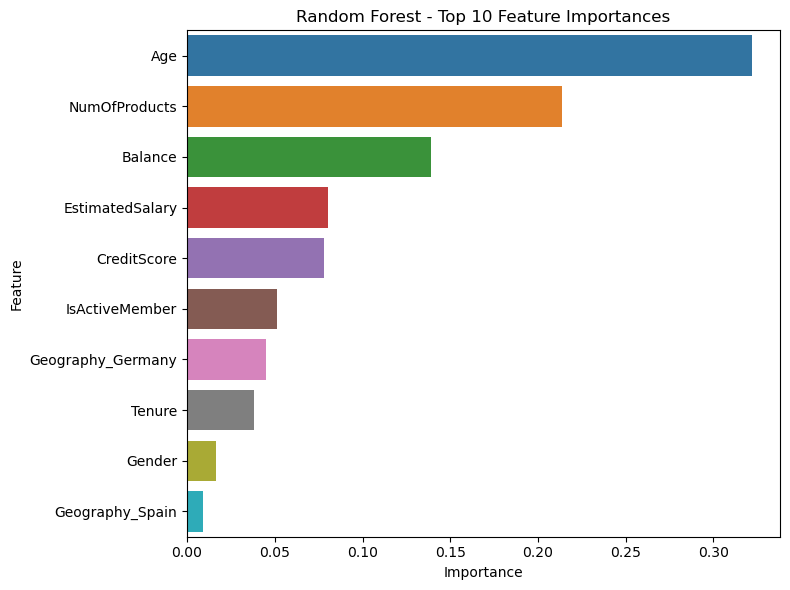

In [187]:
plt.figure(figsize=(8,6))
sns.barplot(x="Importance", y="Feature", data=feat_imp.head(10))
plt.title("Random Forest - Top 10 Feature Importances")
plt.tight_layout()
plt.show()

## Compare with logistic regression & XGBoost

Test Accuracy ->	80.6% (Logistic Regression) //	83.6% (Random Forest (Tuned)) // 86.8% (XGBoost)

Churn Recall ->	19.0% (Logistic Regression) //	67.8% (Random Forest (Tuned))	// 49.0% (XGBoost)

Churn Precision ->	57.0% (Logistic Regression)//	58.4% (Random Forest (Tuned))	// 78.0% (XGBoost)

Churn F1-Score ->	0.29 (Logistic Regression)// 0.627 (Random Forest (Tuned)) // 0.60 (XGBoost)

ROC-AUC Score ->	0.58 (Logistic Regression)// 0.86 (Random Forest (Tuned)) // 0.73 (XGBoost)

- **Logistic regression (the baseline)**

  - Strengths: Simple to understand and highly interpretable (the odds ratios clearly show feature impact)

  - Weakness: It performed very poorly on the main objective. With a recall of only 19%, it failed to identify 81% of the customers who actually churned

Conclusion: While a good starting point, it's not a practical solution for this business problem due to its inability to find at-risk customers

- **Random forest (tuned)**

  - Strengths: this model was the best at identifying churners, correctly flagging 67.8% of them. Its high ROC-AUC score (0.86) also indicates it's the best model at distinguishing between the two classes

  - Weakness: Its precision was slightly lower than the other models, meaning it created more "false positives" (flagging loyal customers as potential churners)

Conclusion: This is the most effective model for the primary business goal. It allows the bank to identify the largest group of at-risk customers to target with retention campaigns

- **XGBoost**

  - Strengths: This model achieved the highest overall accuracy (86.8%) and the highest precision (78%). This means it was the most "correct" in its predictions and had very few false alarms. When it predicted a customer would churn, it was right 78% of the time

  - Weakness: Its recall (49%) was significantly lower than the tuned Random Forest. It successfully identified fewer churners, missing about half of them

Conclusion: A very strong and accurate model, but less effective than the Random Forest for the specific goal of maximising the identification of churners

**Key feature importance comparison**

The models generally agreed on which features were important, but with some differences in priority:

- Consensus Top Features: all three models identified Age, Number of Products, and IsActiveMember as top drivers of churn. Customers from Germany were also consistently shown to have a higher churn risk

Differences:

- XGBoost placed the most importance on NumOfProducts

- Random Forest gave more weight to financial attributes like Balance and EstimatedSalary compared to the other models

- Logistic Regression highlighted the impact of Balance, but less so than Age or IsActiveMember

**Final recommendation**

For the business goal of minimising customer churn, the tuned Random Forest is the recommended model

While XGBoost has higher accuracy, the Random Forest model's superior recall (67.8% vs. 49%) is the deciding factor. It is more valuable for the bank to identify the maximum number of at risk customers, even if it means some loyal customers are incorrectly flagged. The high F1-Score and ROC-AUC further support its selection as the most balanced and effective model for this specific task

## Save model for deployment

In [188]:
joblib.dump(best_rf, "RFC_churn_pipeline.pkl")


['RFC_churn_pipeline.pkl']

In [189]:
#Save cleaned CSV for Tableau / later use
df.to_csv("BankChurners_cleaned.csv", index=False)
print("\nSaved cleaned CSV -> BankChurners_Random_Forest_Classifier_cleaned.csv")


Saved cleaned CSV -> BankChurners_Random_Forest_Classifier_cleaned.csv
